In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
dt = pd.read_csv("sales_cleaned.csv", encoding = "unicode_escape")
df = dt.copy()
df.head()

,ordernumber,productline,quantityordered,dealsize,priceeach,sales,msrp,expsales,profit_loss,orderlinenumber,...,dayordered,yearorders,qtr_id,productcode,customername,contactnames,phone,addressline1,city,country
0,10107,Motorcycles,30,Small,95.70,2871.00,95,2850,21.00,2,...,24,2003,1,S10_1678,Land of Toys Inc.,Kwai Yu,2125557818,897 Long Airport Avenue,NYC,USA
1,10121,Motorcycles,34,Small,81.35,2765.90,95,3230,-464.10,5,...,7,2003,2,S10_1678,Reims Collectables,Paul Henriot,26.47.1555,59 rue de l'Abbaye,Reims,France
2,10134,Motorcycles,41,Medium,94.74,3884.34,95,3895,-10.66,2,...,1,2003,3,S10_1678,Lyon Souveniers,Daniel Da Cunha,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,Paris,France
3,10145,Motorcycles,45,Medium,83.26,3746.70,95,4275,-528.30,6,...,25,2003,3,S10_1678,Toys4GrownUps.com,Julie Young,6265557265,78934 Hillside Dr.,Pasadena,USA
4,10159,Motorcycles,49,Medium,100.00,4900.00,95,4655,245.00,14,...,10,2003,4,S10_1678,Corporate Gift Ideas Co.,Julie Brown,6505551386,7734 Strong St.,San Francisco,USA


## DROPPING COLUMNS THAT MAY NOT BE NEEDED FPR OUR MODELLING

In [3]:
df = df.drop(["orderlinenumber", "status", "dayordered", "yearorders", "productcode",
             "customername", "contactnames", "phone", "addressline1", "ordernumber"], axis = 1)

In [4]:
df.head()

,productline,quantityordered,dealsize,priceeach,sales,msrp,expsales,profit_loss,monthordered,qtr_id,city,country
0,Motorcycles,30,Small,95.70,2871.00,95,2850,21.00,February,1,NYC,USA
1,Motorcycles,34,Small,81.35,2765.90,95,3230,-464.10,May,2,Reims,France
2,Motorcycles,41,Medium,94.74,3884.34,95,3895,-10.66,July,3,Paris,France
3,Motorcycles,45,Medium,83.26,3746.70,95,4275,-528.30,August,3,Pasadena,USA
4,Motorcycles,49,Medium,100.00,4900.00,95,4655,245.00,October,4,San Francisco,USA


## HEATMAP AND CORRELATION

In [5]:
df.corr()

,quantityordered,priceeach,sales,msrp,expsales,profit_loss,qtr_id
quantityordered,1.000000,0.005564,0.748820,0.017881,0.574740,-0.174548,-0.035323
priceeach,0.005564,1.000000,0.643708,0.670625,0.534752,-0.214666,0.008712
sales,0.748820,0.643708,1.000000,0.443152,0.796492,-0.279097,-0.021958
msrp,0.017881,0.670625,0.443152,1.000000,0.799559,-0.832930,0.010234
expsales,0.574740,0.534752,0.796492,0.799559,1.000000,-0.802921,-0.010057
profit_loss,-0.174548,-0.214666,-0.279097,-0.832930,-0.802921,1.000000,-0.005675
qtr_id,-0.035323,0.008712,-0.021958,0.010234,-0.010057,-0.005675,1.000000


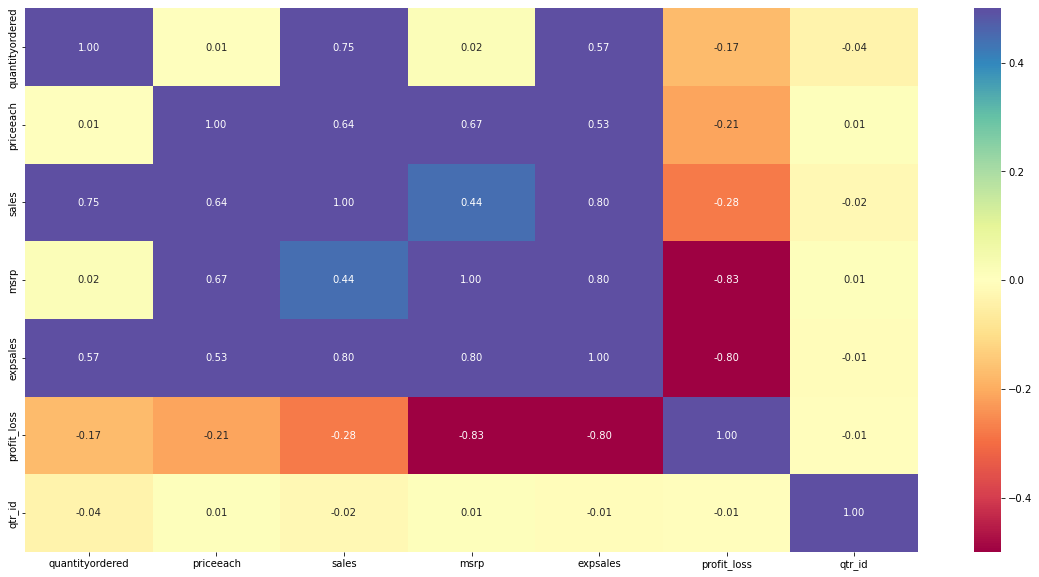

In [6]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),vmin=-0.5,vmax=0.5,annot=True,fmt='.2f',cmap="Spectral")
plt.show()

## SPLITTING OUR DATASET

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   productline      2823 non-null   object 
 1   quantityordered  2823 non-null   int64  
 2   dealsize         2823 non-null   object 
 3   priceeach        2823 non-null   float64
 4   sales            2823 non-null   float64
 5   msrp             2823 non-null   int64  
 6   expsales         2823 non-null   int64  
 7   profit_loss      2823 non-null   float64
 8   monthordered     2823 non-null   object 
 9   qtr_id           2823 non-null   int64  
 10  city             2823 non-null   object 
 11  country          2823 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 264.8+ KB


USING LABEL ENCODER FOR THE OBJECT BASED COLUMNS

In [9]:
obj_col = df.select_dtypes(include = "object").columns
print(obj_col)

Index(['productline', 'dealsize', 'monthordered', 'city', 'country'], dtype='object')


In [10]:
le = LabelEncoder()

for i in obj_col:
    df[i] = le.fit_transform(df[i])

SCALING THE DATASET

In [11]:
scaler = MinMaxScaler()

In [12]:
dl = pd.DataFrame(scaler.fit_transform(df), columns= df.columns)

In [13]:
dl.head()

,productline,quantityordered,dealsize,priceeach,sales,msrp,expsales,profit_loss,monthordered,qtr_id,city,country
0,0.166667,0.263736,1.0,0.941193,0.278877,0.342541,0.185802,0.699682,0.272727,0.000000,0.583333,1.000000
1,0.166667,0.307692,1.0,0.744940,0.266608,0.342541,0.216527,0.654084,0.727273,0.333333,0.777778,0.333333
2,0.166667,0.384615,0.5,0.928063,0.397175,0.342541,0.270294,0.696706,0.454545,0.666667,0.722222,0.333333
3,0.166667,0.428571,0.5,0.771061,0.381107,0.342541,0.301019,0.648050,0.090909,0.666667,0.736111,1.000000
4,0.166667,0.472527,0.5,1.000000,0.515743,0.342541,0.331743,0.720737,0.909091,1.000000,0.819444,1.000000


In [14]:
x = dl.drop(["sales", "priceeach", "expsales", "profit_loss"], axis = 1)
y = dl["expsales"]

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [16]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1976, 8), (1976,), (847, 8), (847,))

### CHECKING WHICH MODEL WILL BE PERFECT

In [17]:
##put the models in a dict

models = {
    "RandomForestRegressor": RandomForestRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "SVR": SVR(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "XGBRegressor": XGBRegressor()
}

In [18]:
##set up a function to test and train the datasets using each model and evaluate them

def model_evaluation(models, X_train, X_test, Y_train, Y_test):
    ##dictionry for the models and their evaluation score
    np.random.seed(42)
    
    score = {}
    
   
    for m_name, model in models.items():
        model.fit(X_train, Y_train)
        
        score[m_name] = model.score(X_test, Y_test)
    return score

In [19]:
%%time
pp = model_evaluation(models = models, 
                      X_train=x_train,
                      X_test=x_test,
                      Y_train=y_train,
                      Y_test=y_test
                      )

pp


Wall time: 2.88 s


{'RandomForestRegressor': 0.9904527608212254,
 'GradientBoostingRegressor': 0.993570730506093,
 'LinearRegression': 0.9543966804111629,
 'Ridge': 0.9540049591718578,
 'Lasso': -0.00103854440483242,
 'SVR': 0.8853517536852026,
 'DecisionTreeRegressor': 0.9793605448029523,
 'KNeighborsRegressor': 0.777156633950947,
 'XGBRegressor': 0.9909505704313132}

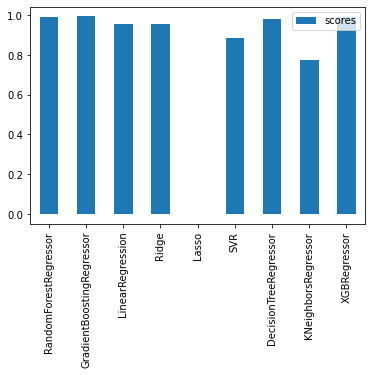

In [20]:
model_compare = pd.DataFrame(pp, index = ["scores"])
# model_compare.plot(kind = "bar", rot = 30)
model_compare.T.plot.bar();

GRADIENT BOOST REGRESSOR IS THE BEST MODEL TO USE BECAUSE IT HAS THE HIGHEST SCORE

### FIT AND PREDICT

In [21]:
grb = GradientBoostingRegressor()

grb.fit(x_train, y_train)

GradientBoostingRegressor()

In [22]:
y_pred = grb.predict(x_test)

In [23]:
model_df = pd.DataFrame({"actual_values": y_test,
                        "prdeicted_values": y_pred})

In [24]:
model_df

,actual_values,prdeicted_values
1091,0.091203,0.091255
2328,0.161546,0.169677
1474,0.308538,0.323187
1437,0.309508,0.294679
1105,0.233506,0.235186
...,...,...
643,0.230918,0.239092
1580,0.152005,0.157924
1298,0.271911,0.275187
1017,0.255983,0.258208


### CALCULATING METRICS

In [25]:
mae = round(mean_absolute_error(y_test, y_pred), 2)
mae

0.01

In [26]:
mse = mean_squared_error(y_test, y_pred).round(2)
mse

0.0

In [27]:
rss = np.sum(np.square(y_test - y_pred)).round(3)
rss

0.118

### SCATTERPLOT

In [28]:
model_df

,actual_values,prdeicted_values
1091,0.091203,0.091255
2328,0.161546,0.169677
1474,0.308538,0.323187
1437,0.309508,0.294679
1105,0.233506,0.235186
...,...,...
643,0.230918,0.239092
1580,0.152005,0.157924
1298,0.271911,0.275187
1017,0.255983,0.258208


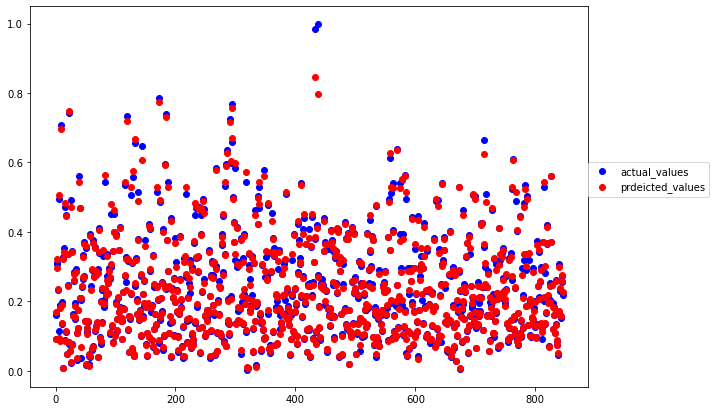

In [29]:
x = np.arange(0, len(model_df), 1)
fig, ax = plt.subplots(figsize = (10, 7))
ax.scatter(x, model_df["actual_values"], color = "blue", label = "actual_values")
ax.scatter(x, model_df["prdeicted_values"], color = "red", label = "prdeicted_values")
ax.legend(loc=(1, 0.5));

MOST OF OUR PREDICTIONS WERE SPOT ON



### DETERMINING WHICH FEATURES WERE IMPORTANT

In [30]:
grb.feature_importances_

array([2.04608871e-06, 3.11127989e-01, 8.25951818e-02, 6.06118916e-01,
       1.82026493e-05, 7.23899319e-06, 1.22281024e-04, 8.14447483e-06])

In [31]:
# creating a function for visualing the feature importances

def plot_importances(columns, importances, n=20):
    df6 = (pd.DataFrame({'features': columns,
                        'feature_importances': importances})
                       .sort_values('feature_importances', ascending=False)
                       .reset_index(drop=False))

    # plotting the dataframe
    fig, ax = plt.subplots(figsize=(10,8))
    ax = sns.barplot(x = 'feature_importances', y = 'features', data = df6[:n], orient='h')
    plt.ylabel('features')
    plt.xlabel('feature_importances')

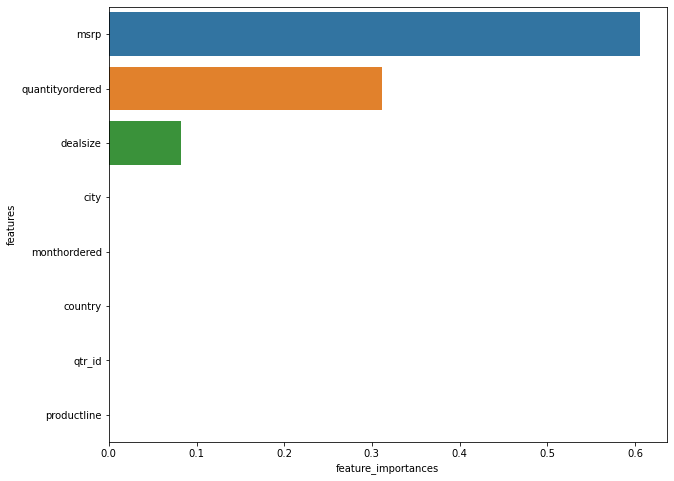

In [32]:
plot_importances(x_train.columns, grb.feature_importances_)

### BY USING MSRP(MANAGEMENT'S STANDARD RETAIL PRICE) WE WERE ABLE TO PREDICT THE EXPECTED SALES THAT WILL BE MADE